# <font color='#018ada'>RVC v2 [Entrenamiento y uso] ¡Ahora con copia de seguridad automatica!</font>
---

**Enlaces que podrían interesarte:**

- [Tutorial para este cuaderno](https://www.youtube.com/watch?v=gTWA2qyzX7k) - [Tutorial para cuaderno tradicional](https://www.youtube.com/embed/R8-PivPpv8o) - [Transferir archivo de mega a Drive](https://colab.research.google.com/drive/1utTesfmBv-uQ8Upa7TEVpM57kmcq9YN6?usp=sharing)
---

Ahora hay solo un paso en colab, carga la interfaz desde la pestaña "Recursos" en gradio

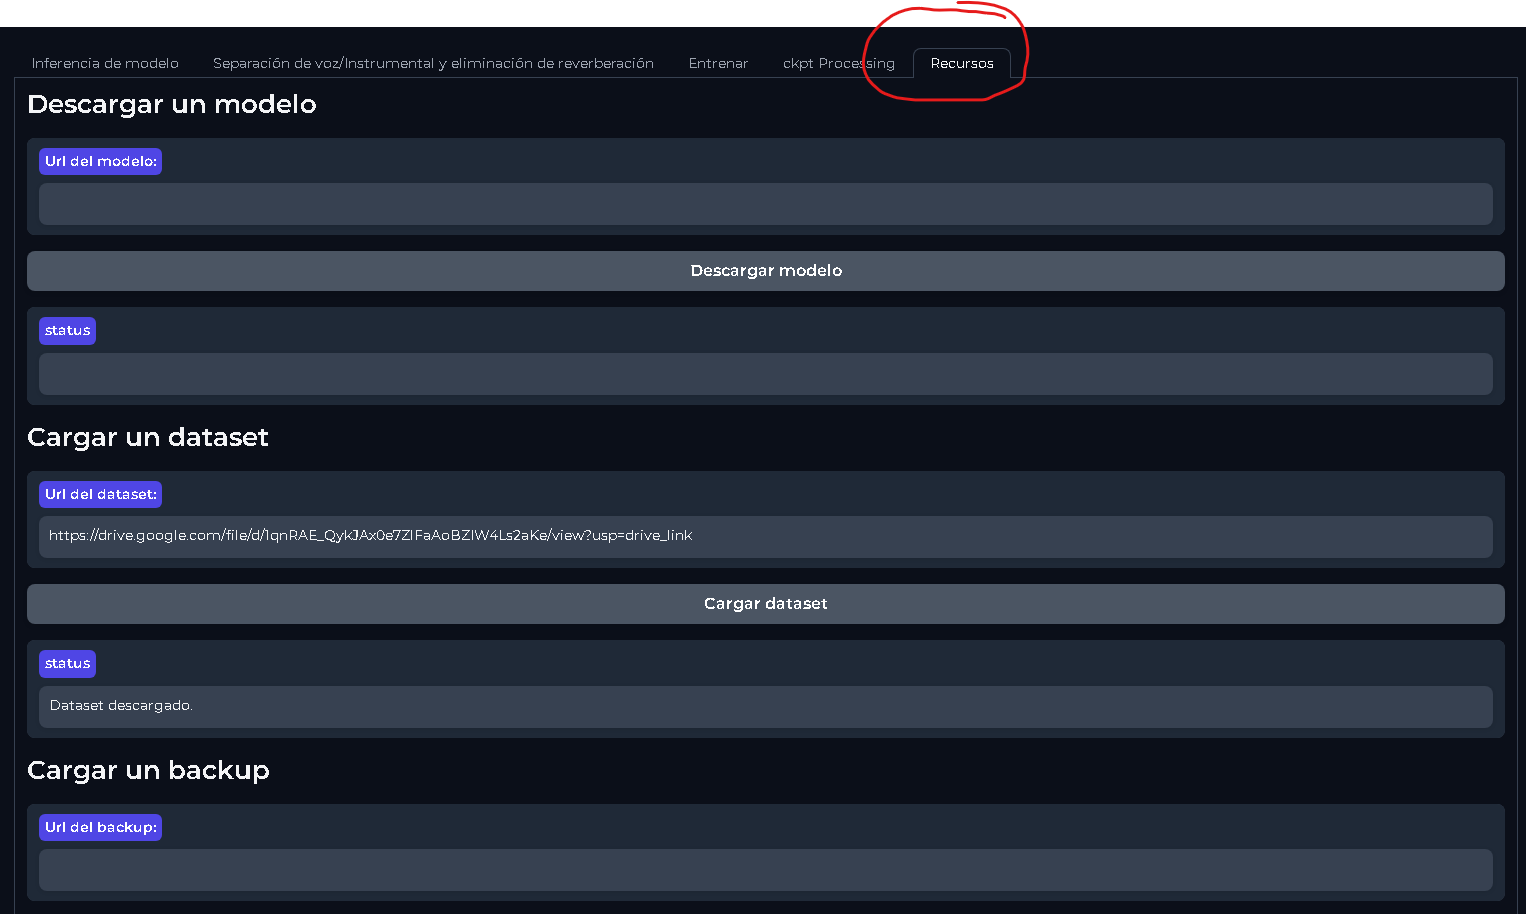


In [ ]:
#@title <font color='#018ada'>Interfaz de gradio (Paso único)</font> { display-mode: "form" }
import os
import threading
import time
import shutil
import hashlib
from urllib.parse import urlparse, parse_qs
from google.oauth2.service_account import Credentials
import pandas as pd
from tqdm import tqdm
import csv
import tarfile
import subprocess
from pathlib import Path
from datetime import datetime
from google.colab import drive
from IPython.display import clear_output
import ipywidgets as widgets

success=widgets.Button(description="\u2714 Hecho",disabled=True, button_style="success")

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print('Drive ya está montado. Continuando...')

!mkdir -p /content/drive/MyDrive/RVC
!mkdir -p /content/drive/MyDrive/dataset
if os.path.exists("/content/temporal_rvc_folder"):
  shutil.rmtree("/content/temporal_rvc_folder")


GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/RVC_Backup' # cambiar a tu ubicacion de drive
LOGS_FOLDER = '/content/Retrieval-based-Voice-Conversion-WebUI/logs'
WEIGHTS_FOLDER = '/content/Retrieval-based-Voice-Conversion-WebUI/weights'
#@markdown Si google colab se desconectó mientras se entrenaba el modelo, puedes cargar la última copia de seguridad guardada en tu Drive
cargar_backup = False #@param{type: 'boolean'}
#@markdown Si deseas crear un backup automatico durante el entrenamiento
crear_backup_automatico = False #@param{type: 'boolean'}
#@markdown Para obtener estadisticas de como va el entrenamiento
usar_tensorboard = False #@param{type: 'boolean'}
#@markdown Si quieres volver a descargar las dependencias
forzar_reinstalacion = True #@param{type: 'boolean'}

# Buscar modelos guardados en drive y restaurarlos en el folder /rvc
def import_google_drive_backup():
    version = "1"
    print("Importando backup de Google Drive...")
    weights_exist = False

    for root, dirs, files in os.walk(GOOGLE_DRIVE_PATH):
        for filename in files:
            filepath = os.path.join(root, filename)
            # Si existen archivos de backups meterlos en la carpeta rvc/logs con metadatos
            if os.path.isfile(filepath) and not filepath.startswith(os.path.join(GOOGLE_DRIVE_PATH, 'weights')):
                backup_filepath = os.path.join(LOGS_FOLDER, os.path.relpath(filepath, GOOGLE_DRIVE_PATH))
                backup_folderpath = os.path.dirname(backup_filepath)
                if not os.path.exists(backup_folderpath):
                    os.makedirs(backup_folderpath)
                    print(f'Se ha creado backup del folder: {backup_folderpath}', flush=True)
                shutil.copy2(filepath, backup_filepath) # Copiar archivo con metadatos
                if '3_feature_768' in filepath:
                  version = "2"
                # print(f'Importado archivo de backup: {filename}')
            # Si el archivo actual pertenece a pesos entonces meterlo a rvc/weights con metadatos
            elif filepath.startswith(os.path.join(GOOGLE_DRIVE_PATH, 'weights')) and filename.endswith('.pth'):
                weights_exist = True
                weights_filepath = os.path.join(WEIGHTS_FOLDER, os.path.relpath(filepath, os.path.join(GOOGLE_DRIVE_PATH, 'weights')))
                weights_folderpath = os.path.dirname(weights_filepath)
                if not os.path.exists(weights_folderpath):
                    os.makedirs(weights_folderpath)
                    print(f'Folder weights creado: {weights_folderpath}', flush=True)
                shutil.copy2(filepath, weights_filepath) # Copiar los metadatos del archivo
                print(f'Archivo importado desde weights: {filename}')

    # if weights_exist:
    #     print("Pesos copiados del backup de Google Drive a la carpeta de pesos local.")
    # else:
    #     print("No se encontraron pesos en el backup de Google Drive.")
    print("Importación del backup completado.")
    #print("Se detectó que el modelo fue entrenado en la versión " + str(version))

def empezar_servidor():
    %cd /content/Retrieval-based-Voice-Conversion-WebUI
    if usar_tensorboard:
      %load_ext tensorboard
      %tensorboard --logdir /content/Retrieval-based-Voice-Conversion-WebUI/logs
    !mkdir -p /content/Retrieval-based-Voice-Conversion-WebUI/audios
    !python3 infer-web.py --colab --pycmd python3


def copiar_folder_pesos_a_drive():
    # Verificar si no existe el folder weights en el folder backup
    destination_folder = os.path.join(GOOGLE_DRIVE_PATH, 'weights')
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    #
    num_copied = 0
    # Copiar los archivos .pth qsi aún no existen en drive
    for filename in os.listdir(WEIGHTS_FOLDER):
        if filename.endswith('.pth'):
            source_file = os.path.join(WEIGHTS_FOLDER, filename)
            destination_file = os.path.join(destination_folder, filename)
            if not os.path.exists(destination_file):
                shutil.copy2(source_file, destination_file)
                num_copied += 1
                print(f"{filename} copiado a Google Drive!")

    # if num_copied == 0:
    #     print("No se encontraron nuevos modelos terminados para copiar.")
    # else:
    #     print(f"¡Terminó de copiar {num_copied} archivos a Google Drive!")


def backup_files():
    print("Iniciando bucle de copia de seguridad...")
    last_backup_timestamps_path = os.path.join(LOGS_FOLDER, 'last_backup_timestamps.txt')
    fully_updated = False  # booleano para rastrear si todos los archivos están actualizados
    try:
        with open(last_backup_timestamps_path, 'r') as f:
            last_backup_timestamps = dict(line.strip().split(':') for line in f)
    except:
        last_backup_timestamps = {}
    while True:
        updated = False # marca para verificar si se actualizó algún archivo
        # Recorrer /content/RVC
        for root, dirs, files in os.walk(LOGS_FOLDER):
            for filename in files:
                if filename != 'last_backup_timestamps.txt':
                    filepath = os.path.join(root, filename)
                    if os.path.isfile(filepath):
                        backup_filepath = os.path.join(GOOGLE_DRIVE_PATH, os.path.relpath(filepath, LOGS_FOLDER))
                        backup_folderpath = os.path.dirname(backup_filepath)
                        if not os.path.exists(backup_folderpath):
                            os.makedirs(backup_folderpath)
                            print(f'Se ha creado un folder backup de: {backup_folderpath}', flush=True)
                        # se comprueba si el archivo ha cambiado desde el ultimo backup
                        last_backup_timestamp = last_backup_timestamps.get(filepath)
                        current_timestamp = os.path.getmtime(filepath)
                        if last_backup_timestamp is None or float(last_backup_timestamp) < current_timestamp:
                            shutil.copy2(filepath, backup_filepath) # copiar archivo con metadata
                            last_backup_timestamps[filepath] = str(current_timestamp) # actualizar las marcas de tiempo
                            if last_backup_timestamp is None:
                              extension = filename.split(".")[-1]
                              # if extension != "npy" and extension != "pt":
                              #   print(f'Se ha creado backup de: {filename}')
                            else:
                              extension = filename.split(".")[-1]
                              # if extension != "npy" and extension != "pt":
                              #   print(f'Se ha actualizado el backup de: {filename}')
                            updated = True
                            fully_updated = False  # si un archivo se actualiza, todos los archivos no están actualizados

        # verificar si se eliminaron archivos en Colab y eliminarlos del backup
        for filepath in list(last_backup_timestamps.keys()):
            if not os.path.exists(filepath):
                backup_filepath = os.path.join(GOOGLE_DRIVE_PATH, os.path.relpath(filepath, LOGS_FOLDER))
                if os.path.exists(backup_filepath):
                    os.remove(backup_filepath)
                    print(f'Deleted file: {filepath}')
                del last_backup_timestamps[filepath]
                updated = True
                fully_updated = False  # si se elimina un archivo, todos los archivos no están actualizados
        if not updated and not fully_updated:
            print("Los archivos están actualizados.")
            fully_updated = True  # si todos los archivos están actualizados, establecer el booleano en True
            copiar_folder_pesos_a_drive()
            sleep_time = 30
        else:
            sleep_time = 1
        with open(last_backup_timestamps_path, 'w') as f:
            for filepath, timestamp in last_backup_timestamps.items():
                f.write(f'{filepath}:{timestamp}\n')
        time.sleep(sleep_time) # esperar 30 segundos antes de verificar nuevamente, o 1s si no está completamente actualizado para acelerar los backup

# Function to install dependencies with progress
def install_packages():
    packages = ['build-essential', 'python3-dev', 'ffmpeg', 'aria2']
    pip_packages = ['pip', 'setuptools', 'wheel', 'httpx==0.23.0', 'faiss-gpu', 'fairseq', 'gradio==3.34.0',
                    'ffmpeg', 'ffmpeg-python', 'praat-parselmouth', 'pyworld', 'numpy==1.23.5',
                    'numba==0.56.4', 'librosa==0.9.2', 'mega.py', 'gdown', 'onnxruntime', 'pyngrok==4.1.12', 'gTTS', 'elevenlabs']

    print("Actualizando e instalando paquetes del sistema...")
    for package in packages:
        print(f"Instalando {package}...")
        subprocess.check_call(['apt-get', 'install', '-qq', '-y', package])

    print("Actualizando e instalando paquetes de pip...")
    subprocess.check_call(['pip', 'install', '--upgrade'] + pip_packages)

    print('Paquetes actualizados.')

# Function to scan a directory and writes filenames and timestamps
def scan_and_write(base_path, output_file):
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        for dirpath, dirs, files in os.walk(base_path):
            for filename in files:
                fname = os.path.join(dirpath, filename)
                try:
                    mtime = os.path.getmtime(fname)
                    writer.writerow([fname, mtime])
                except Exception as e:
                    print(f'Omitiendo archivo inexistente no relevante {fname}: {str(e)}')
    print(f'Finalizado registro de timestamps a {output_file}.')

# Function to compare files
def compare_files(old_file, new_file):
    old_files = {}
    new_files = {}

    with open(old_file, 'r') as f:
        reader = csv.reader(f)
        old_files = {rows[0]:rows[1] for rows in reader}

    with open(new_file, 'r') as f:
        reader = csv.reader(f)
        new_files = {rows[0]:rows[1] for rows in reader}

    removed_files = old_files.keys() - new_files.keys()
    added_files = new_files.keys() - old_files.keys()
    unchanged_files = old_files.keys() & new_files.keys()

    changed_files = {f for f in unchanged_files if old_files[f] != new_files[f]}

    for file in removed_files:
        print(f'File has been removed: {file}')

    for file in changed_files:
        print(f'File has been updated: {file}')

    return list(added_files) + list(changed_files)


def download_dependencies():
  global forzar_reinstalacion

  file_path = '/content/drive/MyDrive/RVC_Cached/CachedRVC.tar.gz'

  content_file_path = '/content/CachedRVC.tar.gz'
  extract_path = '/'

  if not os.path.exists(file_path):
      folder_path = os.path.dirname(file_path)
      os.makedirs(folder_path, exist_ok=True)
      print('"No se encontró ninguna instalación en caché de dependencias. Se intentará descargar una copia de seguridad desde GitHub.".')

      try:
          download_url = "https://github.com/kalomaze/QuickMangioFixes/releases/download/release3/CachedRVC.tar.gz"
          !wget -O $file_path $download_url
          print('Descarga completada exitosamente!')
      except Exception as e:
          print('Descarga fallida:', str(e))

          # Borrar el archivo descargado
          if os.path.exists(file_path):
              os.remove(file_path)
          print('Fallo al descargar el archivo. Continuando con backup manual..')

  if Path(file_path).exists():
      print('CachedRVC.tar.gz encontrado en Drive. Procediendo a copiar y extraer...')
      shutil.copy(file_path, content_file_path)
      print('Iniciando la copia del backup de dependencias...')

      with tarfile.open(content_file_path, 'r:gz') as tar:
          for member in tar.getmembers():
              target_path = os.path.join(extract_path, member.name)
              try:
                  tar.extract(member, extract_path)
              except Exception as e:
                  print('Fallo al decomprimir (esto no es normal)... forzando una actualización para compensar.')
                  install_packages()
          print(f'Extracción  de {content_file_path} a {extract_path} completada.')

      if forzar_reinstalacion:
        install_packages()
        forzar_reinstalacion = False
  else:
      print('CachedRVC.tar.gz no encontrado. Procediendo a crear un indice de todos los archivos actuales...')
      scan_and_write('/usr/', '/content/usr_files.csv')

      install_packages()

      scan_and_write('/usr/', '/content/usr_files_new.csv')
      changed_files = compare_files('/content/usr_files.csv', '/content/usr_files_new.csv')

      with tarfile.open('/content/CachedRVC.tar.gz', 'w:gz') as new_tar:
          for file in changed_files:
              new_tar.add(file)
              print(f'Added to tar: {file}')

      os.makedirs('/content/drive/MyDrive/RVC_Cached', exist_ok=True)
      shutil.copy('/content/CachedRVC.tar.gz', '/content/drive/MyDrive/RVC_Cached/CachedRVC.tar.gz')
      print('Actualizado CachedRVC.tar.gz copiado to Google Drive.')
      print('Dependencias completamente actualizadas; Futuras ejecuciones deberían ser más rapidas.')


def install_rvc():
  # Cambiar el directorio actual a /content/
  os.chdir('/content/')
  if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI"):
    shutil.rmtree("/content/Retrieval-based-Voice-Conversion-WebUI")

  # Clonar el ultimó codigo de Mangio621/Mangio-RVC-Fork
  !git clone https://github.com/xJuuzouYTx/Retrieval-based-Voice-Conversion-WebUI.git Retrieval-based-Voice-Conversion-WebUI &> /dev/null
  os.chdir('/content/Retrieval-based-Voice-Conversion-WebUI')
  print("Actualizando repo a commit 911986d33d4b67c2a1e6166770c9a9d5d613e57a")
  !git checkout 911986d33d4b67c2a1e6166770c9a9d5d613e57a &> /dev/null

  os.chdir('/content')
  # Doescargar el folder torchcrepe de maxrmorrison/torchcrepe
  !git clone https://github.com/maxrmorrison/torchcrepe.git &> /dev/null
  !mv torchcrepe/torchcrepe /content/Retrieval-based-Voice-Conversion-WebUI/
  !rm -rf torchcrepe  # Borrar el folder de torchcrepe

  # Cambiar el directorio actual a /content/Retrieval-based-Voice-Conversion-WebUI
  os.chdir('/content/Retrieval-based-Voice-Conversion-WebUI')
  print("Descargando modelos base...")

  !mkdir -p pretrained pretrained_v2 datasets
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D32k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D48k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G32k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G48k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D32k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D48k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G32k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G48k.pth > /dev/null 2>&1

  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/D40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o D40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/G40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o G40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0D40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0D40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0G40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0G40k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0G48k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0G48k.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0D48k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0D48k.pth > /dev/null 2>&1

  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP2-人声vocals+非人声instrumentals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP2-人声vocals+非人声instrumentals.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP5-主旋律人声vocals+其他instrumentals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP5-主旋律人声vocals+其他instrumentals.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP2_all_vocals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP2_all_vocals.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP3_all_vocals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP3_all_vocals.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP5_only_main_vocal.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP5_only_main_vocal.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/VR-DeEchoAggressive.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o VR-DeEchoAggressive.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/VR-DeEchoDeReverb.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o VR-DeEchoDeReverb.pth > /dev/null 2>&1
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/VR-DeEchoNormal.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o VR-DeEchoNormal.pth > /dev/null 2>&1

  !wget https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/hubert_base.pt -P /content//Retrieval-based-Voice-Conversion-WebUI
  #clear_output()
  clear_output()
  display(success)

try:
  if not os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI") or forzar_reinstalacion:
    !pip install elevenlabs -q
    !pip install gTTS -q
    !pip install wget -q
    !pip install unidecode -q
    !pip install huggingface-hub -q
    download_dependencies()
    install_rvc()

  # Importar modelos antes de iniciar el servidor
  if cargar_backup:
    import_google_drive_backup()

  if crear_backup_automatico:
    # Empezar el servidor en un hilo separadp
    web_server_thread = threading.Thread(target=empezar_servidor)
    web_server_thread.start()

    # Ejecutar el ciclo de backup en el hilo principal
    backup_files()
  else:
    empezar_servidor()
except Exception as e:
  print(e)

In [ ]:
#@title <font color="#018ada">[Utilidades] - Cargar modelo desde url muy usada (Permiso de lectura y escritura avanzada en drive - OPCIONAL)</font>
import os
import shutil
import ipywidgets as widgets

success=widgets.Button(description="\u2714 Hecho",disabled=True, button_style="success")

url = "Introduce tu enlace..." #@param {type: 'string'}
zips_path = "/content/zips"
unzips_path = "/content/unzips"

def delete_temporal_folders():
  if os.path.exists("/content/zips/tempModel.zip"):
    os.remove("/content/zips/tempModel.zip")

  if os.path.exists(zips_path):
    shutil.rmtree(zips_path)

  if os.path.exists(unzips_path):
    shutil.rmtree(unzips_path)

if not os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI"):
  print("Primero debe ejecutar la primera celda para instalar todo.")

  raise Exception("Error de usuario: Ejecute primero la celda de arriba.")

if not os.path.exists(zips_path):
  os.mkdir(zips_path)

if not os.path.exists(unzips_path):
  os.mkdir(unzips_path)

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Obtener id del archivo y descargar
id_archivo = url.split('/')[-2]
downloaded = drive.CreateFile({'id':id_archivo})
downloaded.GetContentFile("/content/zips/tempModel.zip")

shutil.unpack_archive("/content/zips/tempModel.zip", unzips_path, 'zip')
logs_path  ="/content/Retrieval-based-Voice-Conversion-WebUI/logs/"
weights_path  ="/content/Retrieval-based-Voice-Conversion-WebUI/weights/"

index_path = ""
model_path = ""
for root, subfolders, files in os.walk(unzips_path):
  for archivo in files:
    item_path = os.path.join(root, archivo)
    if archivo.endswith('.index'):
      index_path = item_path
    elif archivo.endswith('.pth') and not archivo.startswith("D_") and  not archivo.startswith("G_"):
      model_path = item_path

if model_path:
  modelname = os.path.basename(model_path).replace(".pth","")
  model_logs_dir = os.path.join(logs_path, modelname)

  if not os.path.exists(model_logs_dir):
    os.mkdir(model_logs_dir)

  shutil.move(model_path, os.path.join(weights_path, os.path.basename(model_path)))

  if index_path:
    shutil.move(index_path, os.path.join(model_logs_dir,  os.path.basename(index_path)))

display(success)

delete_temporal_folders()

print("Modelo cargado" if model_path else "Modelo no cargado, está incompleto.")

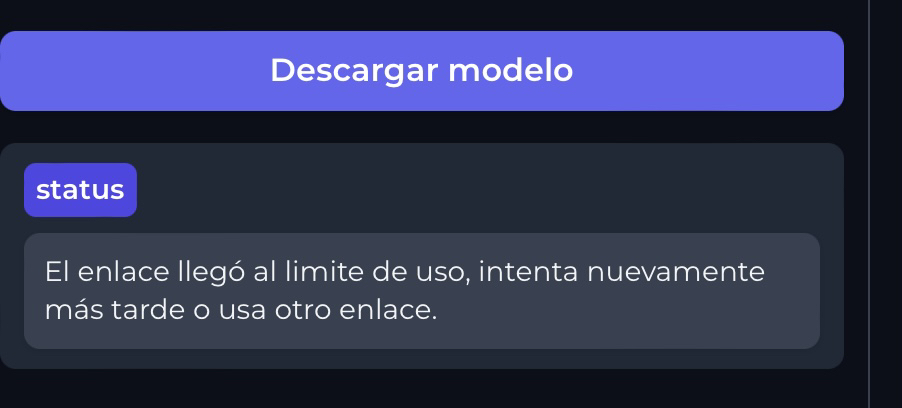

In [ ]:
#@title <font color="#018ada">[Utilidades] Guardar modelos grandes en Drive como (.zip)</font>
#@markdown Si tienes un modelo entrenado y quieres guardarlo para reentrenarlo

import os
import shutil

logs_dir = '/content/Retrieval-based-Voice-Conversion-WebUI/logs/'
output_dir = '/content/drive/MyDrive/RVC_Entrenamiento'

# Obtener la lista de directorios en logs
folders = [folder for folder in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, folder))]

# Crear el directorio de destino
os.makedirs(output_dir, exist_ok=True)

# Iterar cada modelo de logs
for folder in folders:
    if folder == "mute":
      continue

    folder_path = os.path.join(logs_dir, folder)
    zip_file_path = os.path.join(output_dir, f'{folder}_Entrenamiento.zip')

    # Verificar si el zip ya existe en el directorio
    if os.path.exists(zip_file_path):
        existing_size = os.path.getsize(zip_file_path)
        shutil.make_archive(folder_path, 'zip', folder_path)
        new_size = os.path.getsize(f'{folder_path}.zip')
        if existing_size == new_size:
            print(f'Omitido {folder} porqué un zip con el mismo nombre y tamaño ya existe en {output_dir}')
            continue

    # Convertir en zip
    shutil.make_archive(folder_path, 'zip', folder_path)

    # Mover el zip al directorio destino
    shutil.move(f'{folder_path}.zip', zip_file_path)

    print(f'Comprimido {folder} y guardado como {zip_file_path}')

In [ ]:
#@title <font color="#018ada">[Utilidades] Guardar modelos pequeños en Drive como (.zip)</font>
#@markdown Si tienes un modelo entrenado y quieres guardarlo solo para inferencia

import os
import shutil
import zipfile
import re

logs_dir = '/content/Retrieval-based-Voice-Conversion-WebUI/logs/'
weights_dir = '/content/Retrieval-based-Voice-Conversion-WebUI/weights/'
output_dir = '/content/drive/MyDrive/RVC/'
zip_output_dir = '/content/finalzips_forcopying/'
directories = ['/content/finalsavetemp', '/content/finalzips_forcopying']

# Borrar los directorios si existen
for directory in directories:
    if os.path.exists(directory):
        shutil.rmtree(directory)

# Crear los directorios
os.makedirs(output_dir, exist_ok=True)
os.makedirs(zip_output_dir, exist_ok=True)

# Buscar los .pth en weights
pth_files = [file for file in os.listdir(weights_dir) if file.endswith('.pth')]

skipped_files = set()  # Seguimiento de archivos omitidos

for pth_file in pth_files:
    match = re.search(r'(.*)_s\d+.pth$', pth_file)
    if match:  # Omitir si el archivo termina con _s seguido de un numero
        base_name = match.group(1)  # Obtener el nombre del archivo antes de _s<numero>
        if base_name not in skipped_files:
            print(f'Omitiendo archivo de autoguardado: {base_name}.')
            skipped_files.add(base_name)
        continue

    print(f'Procesando archivo: {pth_file}')
    folder = os.path.splitext(pth_file)[0]

    finalsavetemp_dir = '/content/finalsavetemp/'
    os.makedirs(finalsavetemp_dir, exist_ok=True)
    shutil.copy2(os.path.join(weights_dir, pth_file), finalsavetemp_dir)

    if os.path.isdir(os.path.join(logs_dir, folder)):
        index_files = [
            file for file in os.listdir(os.path.join(logs_dir, folder))
            if file.startswith('added') and file.endswith('.index')
        ]

        if index_files:
            latest_index_file = max(
                index_files,
                key=lambda x: os.path.getmtime(os.path.join(logs_dir, folder, x))
            )
            shutil.copy2(
                os.path.join(logs_dir, folder, latest_index_file),
                finalsavetemp_dir
            )
            print(f'Encontrado archivo .index: {latest_index_file}')
        else:
            print("No se encontró un archivo .index. Por favor generalo usando 'generar indice de caracteristicas' si lo entrenaste tu")
    else:
        print("No se encontró un archivo .index. Por favor generalo usando 'generar indice de caracteristicas' si lo entrenaste tu")

    # Crear .zip y meter los archivos dentro
    with zipfile.ZipFile(os.path.join(zip_output_dir, f'{folder}.zip'), 'w') as zipf:
        for root, dirs, files in os.walk(finalsavetemp_dir):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), finalsavetemp_dir))

    print(f'Creado .zip para {folder}.')

    # Borrar 'finalsavetemp'
    shutil.rmtree(finalsavetemp_dir)

    # Copiar el archivo .zip a RVC
    shutil.copy2(os.path.join(zip_output_dir, f'{folder}.zip'), output_dir)
    print(f'Copiado {folder}.zip a {output_dir}')

print('Proceso terminado.')
print('Modelos guardados en Drive/RVC.')

# Delete directories if they exist
for directory in directories:
    if os.path.exists(directory):
        shutil.rmtree(directory)

# <font color="#018ada">[Utilidades] Codigo para quedarse AKF en colab</font>

```javascript
function ClickConnect() {
  var iconElement = document.getElementById("toggle-header-button");
  if (iconElement) {
    var clickEvent = new MouseEvent("click", {
      bubbles: true,
      cancelable: true,
      view: window
    });
    iconElement.dispatchEvent(clickEvent);
  }
}
setInterval(ClickConnect, 6000);

```